# Number of buds per filament - absent vs high (9-12 days)

In [1]:
library(splines)
library(scales)
library(ggplot2)
library(sleuth)

In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest
1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3
4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3


In [4]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [5]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [6]:
d=droplevels(subset(d,! sample %in% exclude ))

In [7]:
variable ="number_buds_per_filament"
variable2 ="number_buds_per_filament"
normal="normal"
alt="high"
table(d[,variable])


   absent      high    normal very_high 
       24         9        27         9 

In [8]:
d[,variable][d[,variable]=="very_high"]="high"
table(d[,variable])


absent   high normal 
    24     18     27 

In [9]:
d=droplevels(subset(d,Time %in% c(9,12) ))
if (!is.null(alt)) {
    d=droplevels(d[d[,variable] %in% c(normal,alt),])
    d[,variable]=factor(d[,variable],levels=c(normal,alt))
}
table(d[,variable])


normal   high 
    18     12 

In [10]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  30 

In [11]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=as.character(paste(m$GENEID,m$class,sep="."))
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

target_id,gene,class,TYPE
Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [12]:
so=sleuth_prep(d, target_mapping = m,aggregation_column = 'gene', 
               gene_mode = TRUE,extra_bootstrap_summary = TRUE,read_bootstrap_tpm=TRUE)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
..............................
normalizing est_counts
45947 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21953 genes passed the filter
Warning message in sleuth_prep(d, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps



In [13]:
options(repr.plot.width=10, repr.plot.height=5)

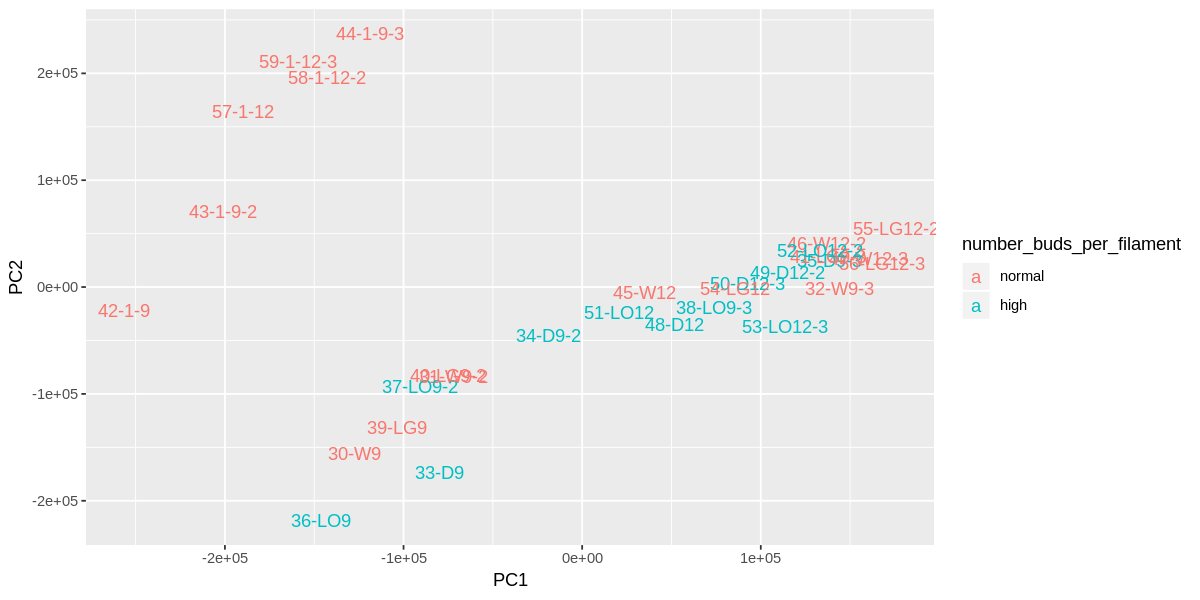

In [14]:
plot_pca(so, color_by = variable,text_labels = TRUE,units='scaled_reads_per_base')

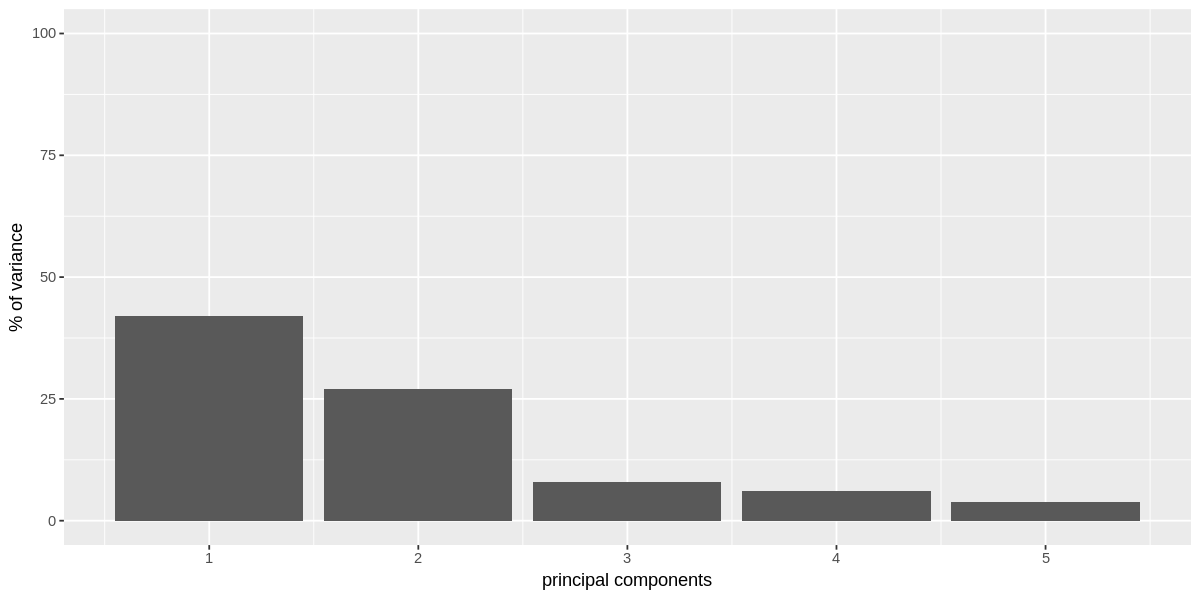

In [15]:
plot_pc_variance(so,units='scaled_reads_per_base')

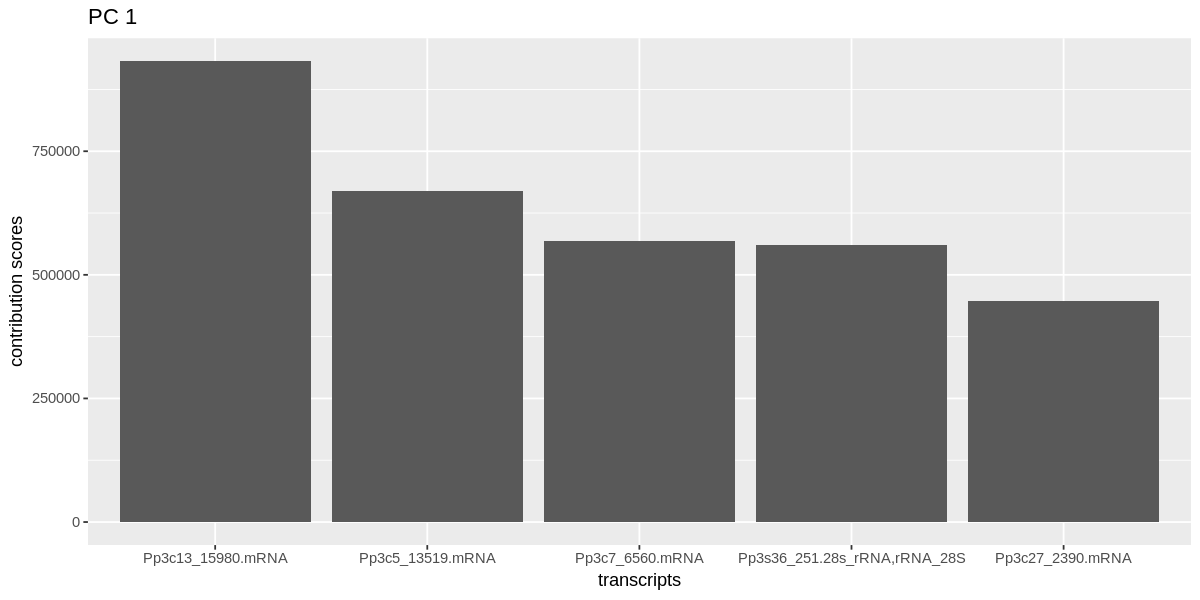

In [16]:
plot_loadings(so, pc_input = 1,units='scaled_reads_per_base')

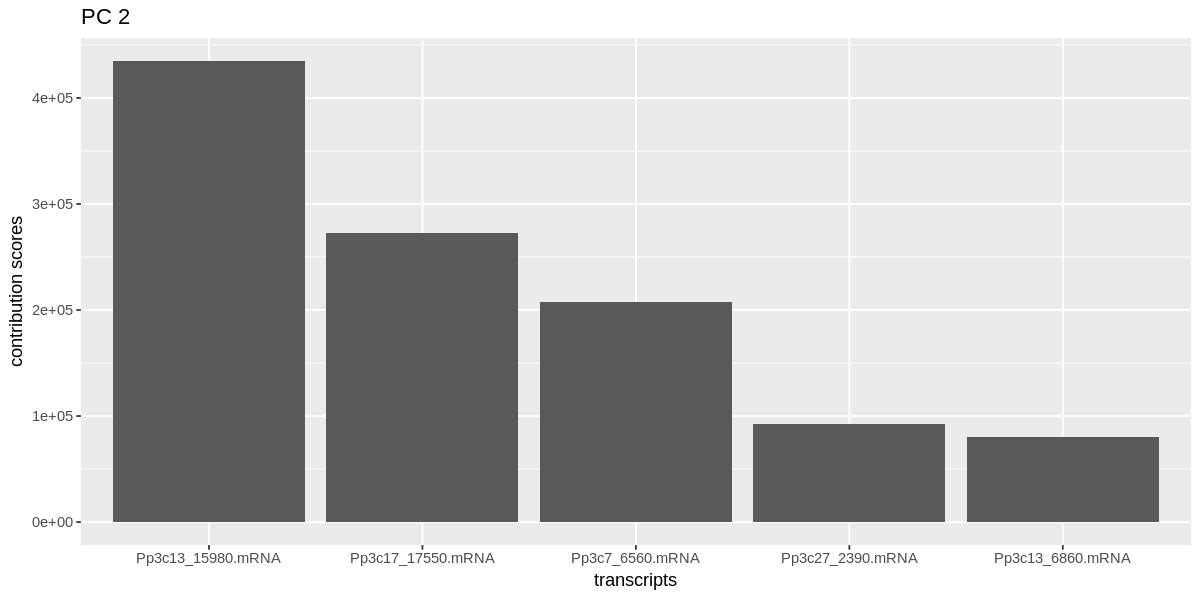

In [17]:
plot_loadings(so, pc_input = 2,units='scaled_reads_per_base')

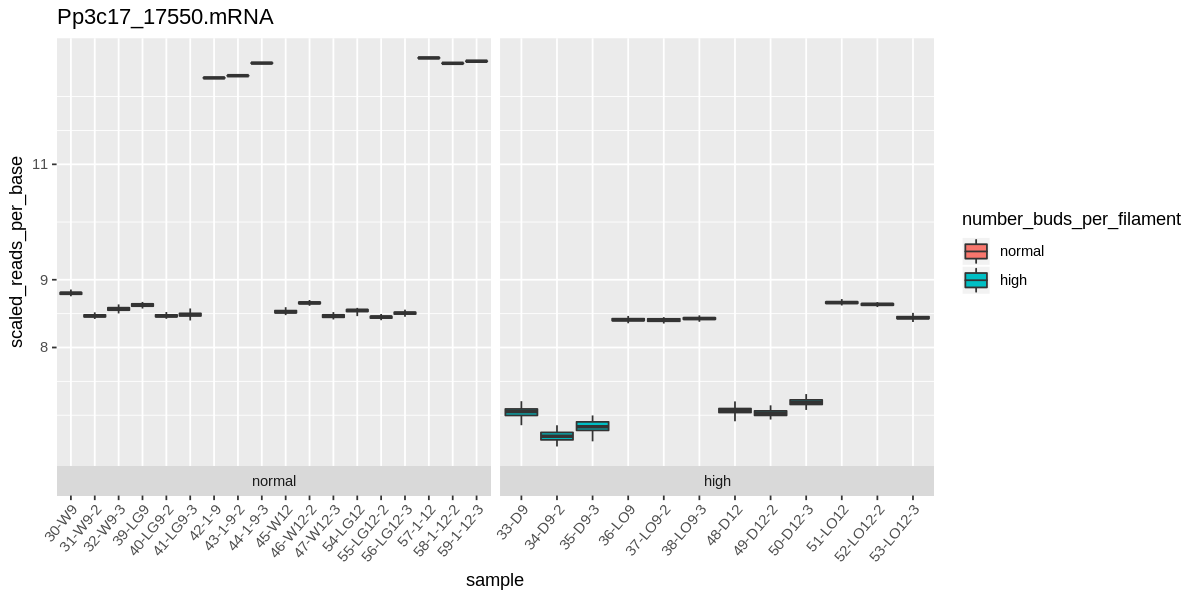

In [18]:
plot_bootstrap(so, 'Pp3c17_17550.mRNA', color_by = variable,units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [19]:
full_design <- model.matrix(as.formula(paste("~ ",variable,"+ factor(batch)",sep="")),data=d)
reduced_design <- model.matrix(formula(~  factor(batch)) ,data=d)

In [20]:
dim(full_design)
head(full_design)

[1] 30  4

,(Intercept),number_buds_per_filamenthigh,factor(batch)2,factor(batch)3
30,1,0,0,0
31,1,0,1,0
32,1,0,0,1
33,1,1,0,0
34,1,1,1,0
35,1,1,0,1


In [21]:
dim(reduced_design)
dim(full_design)

[1] 30  3

[1] 30  4

In [22]:
so= sleuth_fit(so,reduced_design,fit_name="reduced")

fitting measurement error models
shrinkage estimation
8 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Pp3c10_4940.ncRNA, Pp3c5_9210.mRNA, Pp3s1085_40.rRNA_18S, Pp3s300_49.28s_rRNA,rRNA_28S, Pp3s37_40.mRNA, Pp3s71_39.28s_rRNA,rRNA_28S, Pp3s745_3.rRNA_18S, Pp3c13_15980.mRNA
computing variance of betas


In [23]:
so= sleuth_fit(so, full_design, fit_name = "full")

fitting measurement error models
shrinkage estimation
8 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Pp3c10_4940.ncRNA, Pp3c5_9210.mRNA, Pp3s1085_40.rRNA_18S, Pp3s300_49.28s_rRNA,rRNA_28S, Pp3s37_40.mRNA, Pp3s71_39.28s_rRNA,rRNA_28S, Pp3s745_3.rRNA_18S, Pp3c13_15980.mRNA
computing variance of betas


In [24]:
so = sleuth_lrt(so, "reduced", "full")

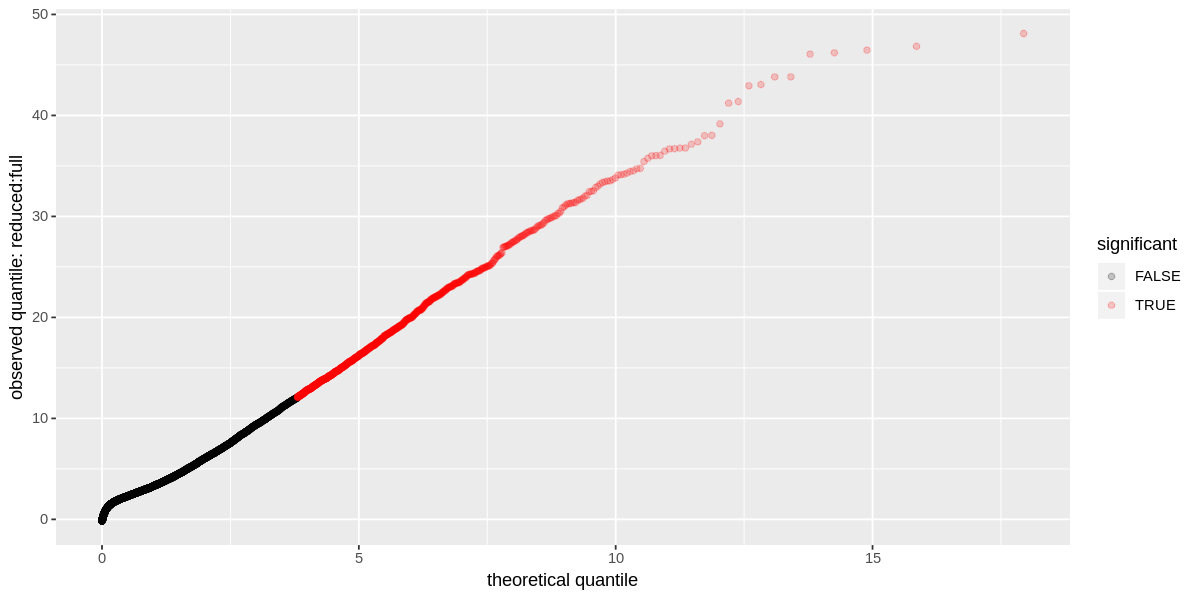

In [25]:
plot_qq(so, test = 'reduced:full', test_type = 'lrt', sig_level = 0.01)

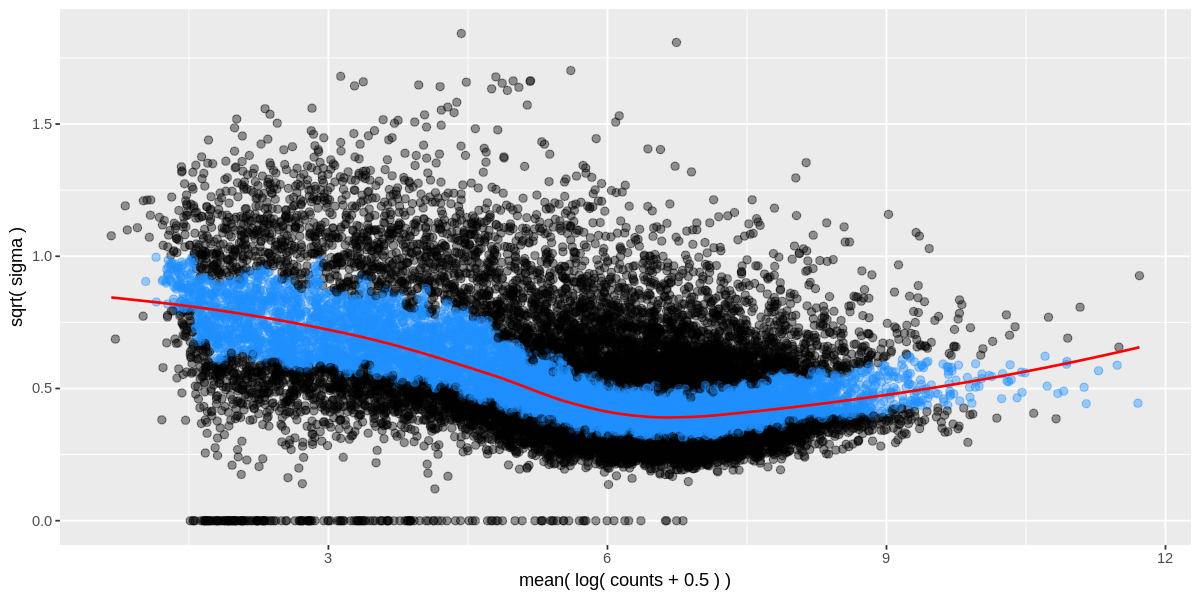

In [26]:
plot_mean_var(so,which_model="full")

In [27]:
lrt_results= sleuth_results(so, 'reduced:full', test_type = 'lrt',show_all=TRUE)
table(lrt_results$qval<0.01)


FALSE  TRUE 
20831  1122 

In [28]:
models(so)

[  reduced  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,  0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,  0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,  1, 0, 0, 1, 0, 0, 1, 0, 0, 1), .Dim = c(30L, 3L), .Dimnames = list(     c("30", "31", "32", "33", "34", "35", "36", "37", "38", "39",      "40", "41", "42", "43", "44", "45", "46", "47", "48", "49",      "50", "51", "52", "53", "54", "55", "56", "57", "58", "59"     ), c("(Intercept)", "factor(batch)2", "factor(batch)3")), assign = c(0L,  1L, 1L), contrasts = list("factor(batch)" = "contr.treatment")) 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	factor(batch)2
 	factor(batch)3
[  full  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,  1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 

In [29]:
so=sleuth_wt(so, which_beta = colnames(full_design)[2], which_model = 'full')
tt=sleuth_results(so,colnames(full_design)[2],"wt")
tt.sig= dplyr::filter(tt, qval < 0.01)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 1296


FALSE  TRUE 
  591   705 

In [30]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
10686 11267 

,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,tech_var.wt,sigma_sq.wt,smooth_sigma_sq.wt,final_sigma_sq.wt
37807,Pp3s51_30.mRNA,mRNA,mRNA,2.649095e-09,2.236754e-06,35.42613,270.6913,1,3.070992,9.775524,⋯,1.528210e-14,1.458643e-11,5.109243,0.6648205,3.070992,9.775524,1.18040670,2.0018945,0.26413807,2.0018945
10435,Pp3c16_14660.mRNA,mRNA,mRNA,1.041587e-05,6.745119e-04,19.43359,288.3324,1,3.709899,10.618626,⋯,1.007666e-06,6.869964e-05,4.380187,0.8957190,3.709899,10.618626,0.67395279,5.1026974,0.19428619,5.1026974
4775,Pp3c11_7530.mRNA,mRNA,mRNA,5.280441e-06,4.087739e-04,20.73278,250.2857,1,4.819859,8.661396,⋯,3.204341e-07,2.658352e-05,4.173942,0.8166563,4.819859,8.661396,0.03097134,4.7709068,0.08766651,4.7709068
4763,Pp3c11_7360.mRNA,mRNA,mRNA,5.432653e-06,4.155507e-04,20.67836,190.0271,1,3.944475,6.561590,⋯,3.365001e-07,2.735995e-05,3.633653,0.7122344,3.944475,6.561590,0.01424682,3.6381534,0.16848697,3.6381534
4388,Pp3c11_2480.mRNA,mRNA,mRNA,1.145528e-11,5.029556e-08,46.06228,119.5039,1,2.008608,4.149444,⋯,1.671994e-22,7.341057e-19,3.610937,0.3699741,2.008608,4.149444,0.13924471,0.8462973,0.38073369,0.8462973
23755,Pp3c26_3080.mRNA,mRNA,mRNA,1.659423e-06,1.759870e-04,22.95380,156.2259,1,3.151354,5.409150,⋯,4.045050e-08,4.748716e-06,3.412752,0.6217582,3.151354,5.409150,0.07143745,2.7119623,0.25539313,2.7119623


In [31]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [32]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

GENEID,name
Pp3c10_13310,XTH28
Pp3c10_13800,"chr1545,CHR1545"
Pp3c10_13960,"CHLH1,CHLH2,chlh2,chlh1"
Pp3c10_13970,"chlh1,chlh2,CHLH2,CHLH1"
Pp3c10_14020,"RABA53,raba53"
Pp3c10_14800,"PPR_20,ppr_20"


In [33]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

GENEID,source,defline
Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [34]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

superfamily,GENEID,inferred_by_rule,TAP_class
BSD domain containing,Pp3c11_12590V3,True,PT
BSD domain containing,Pp3c1_21290V3,True,PT
BSD domain containing,Pp3c20_12230V3,True,PT
BSD domain containing,Pp3c23_10600V3,True,PT
BSD domain containing,Pp3c24_7080V3,True,PT
BSD domain containing,Pp3c26_14480V3,True,PT


In [35]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21953

[1] 21953

[1] 21953

[1] 21953

[1] 21953

,GENEID,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
13731,Pp3c24_5330,Pp3c24_5330.mRNA,mRNA,mRNA,4.025330e-12,5.029556e-08,48.11211,14.848392,1,5.140348,⋯,true,"true,false",protein_coding_gene,false,NA,NA,NA,NA,NA,NA
1374,Pp3c1_8740,Pp3c1_8740.mRNA,mRNA,mRNA,7.672192e-12,5.029556e-08,46.84773,19.897292,1,4.204884,⋯,true,false,protein_coding_gene,false,NA,pdef,KOG1319 - bHLHZip transcription factor BIGMAX (1 of 3),NA,NA,NA
15250,Pp3c3_13600,Pp3c3_13600.mRNA,mRNA,mRNA,9.338755e-12,5.029556e-08,46.46252,265.373241,1,2.982453,⋯,true,true,protein_coding_gene,false,NA,pdef,PTHR33227:SF4 - F12F1.21 PROTEIN (1 of 2),NA,NA,NA
2969,Pp3c11_5700,Pp3c11_5700.mRNA,mRNA,mRNA,1.067189e-11,5.029556e-08,46.20107,3.269426,1,6.364174,⋯,true,false,protein_coding_gene,false,NA,pdef,PF07911 - Protein of unknown function (DUF1677) (DUF1677) (1 of 4),NA,NA,NA
2776,Pp3c11_2480,Pp3c11_2480.mRNA,mRNA,mRNA,1.145528e-11,5.029556e-08,46.06228,119.503942,1,2.008608,⋯,"true,false",false,protein_coding_gene,false,NA,pdef,PF14368 - Probable lipid transfer (LTP_2) (1 of 63),NA,NA,NA
3031,Pp3c11_7600,Pp3c11_7600.mRNA,mRNA,mRNA,3.601907e-11,1.132167e-07,43.81900,69.815944,1,4.871604,⋯,true,false,protein_coding_gene,false,NA,pdef,PF14368 - Probable lipid transfer (LTP_2) (1 of 63),NA,NA,NA


In [36]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7462
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
class.lrt,mRNA
TYPE.lrt,mRNA
pval.lrt,0.001329284
qval.lrt,0.0189987
test_stat,10.30141
rss,123.8264
degrees_free,1
mean_obs.lrt,8.136576


In [37]:
table(o$qval.lrt<0.01)


FALSE  TRUE 
20831  1122 

In [38]:
head(O[,c("target_id","test_stat","qval.lrt","qval.wt","b","name","superfamily","has_evidence","TAP_class","defline")],n=50)

,target_id,test_stat,qval.lrt,qval.wt,b,name,superfamily,has_evidence,TAP_class,defline
13731,Pp3c24_5330.mRNA,48.11211,5.029556e-08,4.834736e-20,-1.2842458,NA,NA,true,NA,NA
1374,Pp3c1_8740.mRNA,46.84773,5.029556e-08,6.907542e-19,-1.4794231,NA,NA,true,NA,KOG1319 - bHLHZip transcription factor BIGMAX (1 of 3)
15250,Pp3c3_13600.mRNA,46.46252,5.029556e-08,6.907542e-19,-5.3906541,NA,NA,true,NA,PTHR33227:SF4 - F12F1.21 PROTEIN (1 of 2)
2969,Pp3c11_5700.mRNA,46.20107,5.029556e-08,6.907542e-19,-0.5976377,NA,NA,true,NA,PF07911 - Protein of unknown function (DUF1677) (DUF1677) (1 of 4)
2776,Pp3c11_2480.mRNA,46.06228,5.029556e-08,7.341057e-19,3.6109373,NA,NA,true,NA,PF14368 - Probable lipid transfer (LTP_2) (1 of 63)
3031,Pp3c11_7600.mRNA,43.81900,1.132167e-07,4.373339e-17,2.7305796,NA,NA,true,NA,PF14368 - Probable lipid transfer (LTP_2) (1 of 63)
14515,Pp3c26_14380.mRNA,43.81458,1.132167e-07,4.373339e-17,-5.5131385,NA,NA,true,NA,NA
2848,Pp3c11_26540.mRNA,43.05575,1.375464e-07,1.728198e-11,2.1494836,NA,NA,true,NA,"PF03256 - Anaphase-promoting complex, subunit 10 (APC10) (ANAPC10) (1 of 2)"
10738,Pp3c20_16650.mRNA,42.94192,1.375464e-07,1.846739e-12,-0.5721182,NA,NA,true,NA,NA
13750,Pp3c24_5980.mRNA,41.37659,2.718029e-07,3.253355e-15,-0.6255136,NA,NA,true,NA,6.3.4.21 - Nicotinate phosphoribosyltransferase / Nicotinic acid phosphoribosyltransferase (1 of 1)


In [39]:
plot_transcript_heatmap(so, head(O, n = 25)$target_id)

In [40]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.01)[,c("target_id","test_stat","qval.lrt","qval.wt","b","Alias")]

target_id,test_stat,qval.lrt,qval.wt,b,Alias


In [41]:
dir.create(file.path("factors"), showWarnings = FALSE)
dir=sprintf("factors/%s.%s_vs_%s",variable2,normal,alt)
dir.create(file.path(dir), showWarnings = FALSE)

write.table(o,gzfile(paste(dir,"dge.tsv.gz",sep="/")),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile(paste(dir,"dge.full.tsv.gz",sep="/")),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)